# Arquitectura SRGAN
Esta es una arquitectura Super-Resolution Generative Adversarial Network (SRGAN) utilizando TensorFlow y Keras. SRGAN es un tipo de red neuronal que utiliza un modelo generador y uno discriminador para producir imágenes de alta resolución a partir de imágenes de baja resolución. El principal objetivo de SRGAN es mejorar la resolución de imágenes con detalles impresionantemente realistas.

## Componentes del SRGAN:

### Generador:

Entrada: Imágenes de baja resolución (256x256 píxeles en este caso, en escala de grises debido a channels=1).
Primera capa convolucional: Para la extracción inicial de características.
Capas recursivas: 20 capas convolucionales iterativas, manteniendo el tamaño y profundidad de las características constantes en 64 filtros, utilizadas para refinar las características. No se utiliza Dropout en estas capas, lo que es típico para las redes enfocadas en imágenes.
Reconstrucción: Capa convolucional final que devuelve la imagen de alta resolución (de igual tamaño que la entrada).

### Discriminador:

Entrada: Imágenes (tanto reales de alta resolución como generadas por el generador).
Red convolucional: Varias capas convolucionales con activación LeakyReLU y aumentando el número de filtros gradualmente desde 64 hasta 512. Con cada capa convolucional, se reduce a la mitad el tamaño de la imagen usando un stride de 2.
Salida: Capa densa que determina si la imagen es real (entrenada para detectar las generadas de las reales).

## Flujo de entrenamiento:

### Creación y Compilación de Modelos:

El discriminador se compila primero de forma independiente.
Posteriormente, se configura el modelo adversarial (gan_model), compuesto por el generador y el discriminador. Se desactiva el entrenamiento del discriminador (trainable=False) cuando se entrena el generador dentro del GAN.
El gan_model se compila para optimizar el generador, utilizando una pérdida que compara las imágenes generadas con las imágenes de alta resolución verdaderas, en este caso, error absoluto medio (mean_absolute_error que se asocia típicamente con regresiones).

### Entrenamiento:

gan_model.fit() se usa para entrenar el modelo utilizando conjuntos de datos de baja y alta resolución, especificando número de épocas, tamaño de lote y datos de validación.

### Análisis y Mejoras:
Se utilizan 20 capas en el generador sin capas de normalización o Dropout; esto podría llevar a un sobreajuste si no se maneja correctamente. Podría ser útil añadir normalización, como Batch Normalization, después de cada capa convolucional para mejorar la estabilidad del entrenamiento.
El discriminador utiliza una arquitectura estándar con aumentos progresivos en el número de filtros y reducción del tamaño de las imágenes; es clave para una evaluación efectiva de la "realidad" de las imágenes generadas.

El uso del error absoluto medio para la pérdida del generador implica un enfoque directo en minimizar la diferencia de píxeles entre las imágenes generadas y las reales, apropiado para tareas de regresión visual como super-resolución.



## Importar librerías

In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
import math
from tensorflow import keras
from keras.callbacks import EarlyStopping



In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Definir las métricas

In [3]:
# Definir la métrica SSIM
def ssim_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    ssim_value = tf.map_fn(lambda x: tf.image.ssim(x[0], x[1], max_val=1.0), (y_true, y_pred), dtype=tf.float32)
    return tf.reduce_mean(ssim_value)

# Definir la métrica PSNR
def psnr_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_value)

## Carga de los datasets

In [4]:
# Ruta de los archivos DICOM
path_files = '/Users/charlesdaza/Downloads/IDA/PPMI/3D/1.5 Tesla/Sagital'
files_dcm = []

# Recorrer todas las carpetas y subcarpetas
for root, dirs, files in os.walk(path_files):
    images_dcm = [os.path.join(root, file) for file in files if file.endswith('.dcm')]
    images_dcm.sort(key=lambda x: int(pydicom.dcmread(x).InstanceNumber))
    files_dcm.extend(images_dcm)

# Comprobar la cantidad de archivos DICOM encontrados
print(f"Total de archivos DICOM encontrados: {len(files_dcm)}")

# Cargar imágenes que son exactamente de 256x256
images_mri = []
for archivo in files_dcm:
    img = pydicom.dcmread(archivo).pixel_array
    if img.shape == (256, 256):
        images_mri.append(img.astype(np.float32) / 255.0)  # Normalizar a [0, 1]

print(f"Total de imágenes de 256x256 encontradas: {len(images_mri)}")

if images_mri:
    high_img_mri = np.stack(images_mri, axis=0)
    print(f"Forma del volumen de imágenes: {high_img_mri.shape}")
else:
    print("No se encontraron imágenes de 256x256.")

Total de archivos DICOM encontrados: 55858
Total de imágenes de 256x256 encontradas: 31474
Forma del volumen de imágenes: (31474, 256, 256)


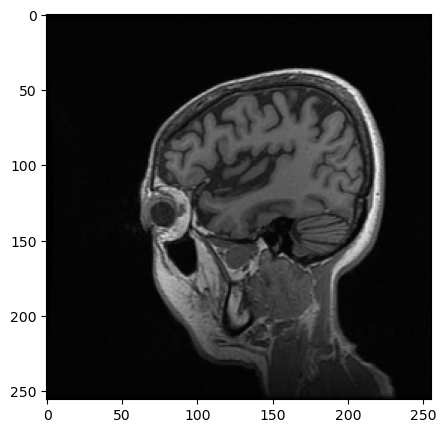

In [5]:
# Ver imágenes de resonancia magnética
plt.figure(figsize=(5, 5))
plt.imshow(high_img_mri[870], cmap='gray')

## Reducción de la resolución

Forma de las imágenes de baja resolución: (31474, 256, 256)


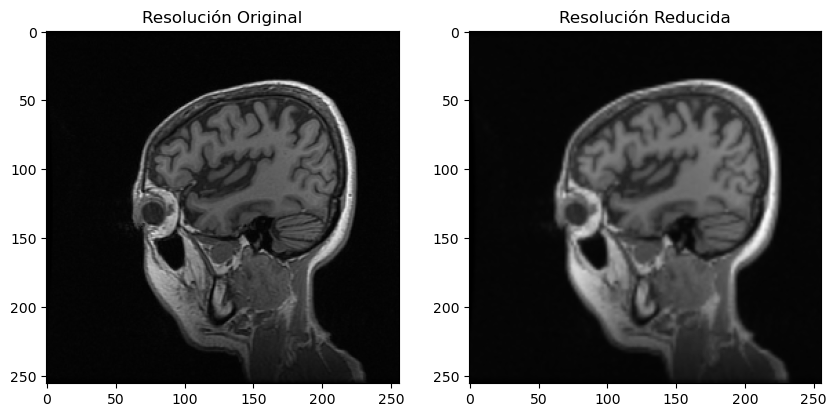

In [6]:
# Reducir resolución
def low_res_image(images, factor):
    if images is None or len(images) == 0:
        print("No hay imágenes válidas para procesar.")
        return None

    # Normalizar y procesar imágenes en un solo paso
    low_res_images = [
        cv2.resize(
            cv2.resize(image.astype(np.float32), 
                       (int(image.shape[1] * factor), int(image.shape[0] * factor)), 
                       interpolation=cv2.INTER_AREA),
            (image.shape[1], image.shape[0]), 
            interpolation=cv2.INTER_LINEAR
        ) / 255.0
        for image in images if image is not None and image.size > 0
    ]

    if not low_res_images:
        print("No se generaron imágenes de baja resolución.")
        return None

    return np.stack(low_res_images, axis=0)

# Factor de reducción de resolución
factor_res = 0.5

# Verificar si las imágenes de entrada son válidas
if high_img_mri is not None and high_img_mri.size > 0:
    low_img_mri = low_res_image(high_img_mri, factor_res)
    if low_img_mri is not None:
        print(f"Forma de las imágenes de baja resolución: {low_img_mri.shape}")
else:
    print("No hay imágenes válidas para procesar.")

# Visualización de una imagen de alta y baja resolución
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(high_img_mri[870], cmap='gray')
plt.title('Resolución Original')
plt.subplot(1, 2, 2)
plt.imshow(low_img_mri[870], cmap='gray')
plt.title('Resolución Reducida')
plt.show()

## Dimensionamiento, upsampling y downsampling

In [7]:
# Tamaño de las imágenes después del preprocesamiento
SIZE = 256

# Definir porcentajes para división de datos
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Total de imágenes
total_images = len(high_img_mri)

# Calcular índices para dividir los datos
train_end = int(total_images * train_ratio)
validation_end = train_end + int(total_images * validation_ratio)

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_high_mri, train_low_mri = high_img_mri[:train_end], low_img_mri[:train_end]
validation_high_mri, validation_low_mri = high_img_mri[train_end:validation_end], low_img_mri[train_end:validation_end]
test_high_mri, test_low_mri = high_img_mri[validation_end:], low_img_mri[validation_end:]

# Añadir una dimensión para cumplir con el formato de entrada del modelo
def add_channel_dimension(images):
    return np.reshape(images, (len(images), SIZE, SIZE, 1))

train_high_mri = add_channel_dimension(train_high_mri)
train_low_mri = add_channel_dimension(train_low_mri)
validation_high_mri = add_channel_dimension(validation_high_mri)
validation_low_mri = add_channel_dimension(validation_low_mri)
test_high_mri = add_channel_dimension(test_high_mri)
test_low_mri = add_channel_dimension(test_low_mri)

# Imprimir las formas de los conjuntos de datos
print("Shape of training mri:", train_high_mri.shape)
print("Shape of validation mri:", validation_high_mri.shape)
print("Shape of test mri:", test_high_mri.shape)

# Definir el modelo de downsample
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential([
        layers.Conv2D(filters, kernel_size, padding='same', strides=2),
        layers.BatchNormalization() if apply_batch_normalization else layers.Activation('linear'),
        layers.LeakyReLU()
    ])
    return downsample

# Definir el modelo de upsample
def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential([
        layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2),
        layers.Dropout(0.2) if dropout else layers.Activation('linear'),
        layers.LeakyReLU()
    ])
    return upsample

Shape of training mri: (25179, 256, 256, 1)
Shape of validation mri: (3147, 256, 256, 1)
Shape of test mri: (3148, 256, 256, 1)


## Definición de la arquitectura

In [ ]:
# Parámetros del modelo
low_res_image_height, low_res_image_width = 256, 256
channels = 1  # Escala de grises

# Número de iteraciones recursivas
num_recursive_layers = 20  # VDSR utiliza más capas recursivas que DRCN


# Definición del generador (SRGAN)
def build_generator():
    inputs = layers.Input(shape=(low_res_image_height, low_res_image_width, channels))

    # Primera capa convolucional (extracción de características inicial)
    feature_extraction = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)

    # Capas recursivas sin Dropout
    recursive_features = feature_extraction
    for _ in range(num_recursive_layers):
        recursive_features = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(recursive_features)

    # Reconstrucción (salida final)
    output = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(recursive_features)

    return Model(inputs=[inputs], outputs=[output])

# Definición del discriminador (SRGAN)
def build_discriminator():
    inputs = layers.Input(shape=(low_res_image_height, low_res_image_width, channels))

    # Capas del discriminador
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, (3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=[inputs], outputs=[output])

# Crear el generador y el discriminador
generator = build_generator()
discriminator = build_discriminator()

# Compilar el discriminador
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

# Compilar el modelo GAN
discriminator.trainable = False  # No entrenar el discriminador durante el entrenamiento del generador

gan_input = layers.Input(shape=(low_res_image_height, low_res_image_width, channels))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan_model = Model(inputs=gan_input, outputs=generated_image)

gan_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='mean_absolute_error',
    metrics=[psnr_metric, ssim_metric]  # Añadir métricas aquí
)

# Resumen de los modelos
generator.summary()
discriminator.summary()
gan_model.summary()




2025-05-26 16:06:32.724605: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-26 16:06:32.724760: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-26 16:06:32.724773: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-26 16:06:32.724799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 16:06:32.724814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,777 (2.82 MB)

 Trainable params: 739,777 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,680,897 (6.41 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,680,897 (6.41 MB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 256, 256, 1)    │       739,777 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,777 (2.82 MB)

 Trainable params: 739,777 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [9]:
from datetime import datetime
# Ver la hora de inicio del entrenamiento
start_time = datetime.now()
print(f"Entrenamiento comenzó a las: {start_time.strftime('%H:%M:%S')}")

Entrenamiento comenzó a las: 16:06:33


In [ ]:
# Entrenamiento del modelo
history = gan_model.fit(train_low_mri, train_high_mri, 
                         epochs=30,
                         batch_size=32, 
                         validation_data=(validation_low_mri, validation_high_mri))


Epoch 1/30


/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


Instructions for updating:
Use fn_output_signature instead


2025-05-26 16:06:53.563716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


787/787 ━━━━━━━━━━━━━━━━━━━━ 1263s 2s/step - loss: 0.3600 - psnr_metric: 16.4360 - ssim_metric: 0.3645 - val_loss: 0.1184 - val_psnr_metric: 23.6849 - val_ssim_metric: 0.5749
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1312s 2s/step - loss: 0.1565 - psnr_metric: 22.9080 - ssim_metric: 0.6099 - val_loss: 0.0887 - val_psnr_metric: 27.2197 - val_ssim_metric: 0.7726
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1310s 2s/step - loss: 0.1133 - psnr_metric: 25.9842 - ssim_metric: 0.7594 - val_loss: 0.0737 - val_psnr_metric: 27.2063 - val_ssim_metric: 0.8034
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1308s 2s/step - loss: 0.1033 - psnr_metric: 26.7659 - ssim_metric: 0.7922 - val_loss: 0.0658 - val_psnr_metric: 29.0821 - val_ssim_metric: 0.8264
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1325s 2s/step - loss: 0.0947 - psnr_metric: 27.3486 - ssim_metric: 0.8121 - val_loss: 0.1142 - val_psnr_metric: 26.5803 - val_ssim_metric: 0.8190
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1314s 2s/step - loss: 0.0947 - psnr_metri

## Visualización de las métricas

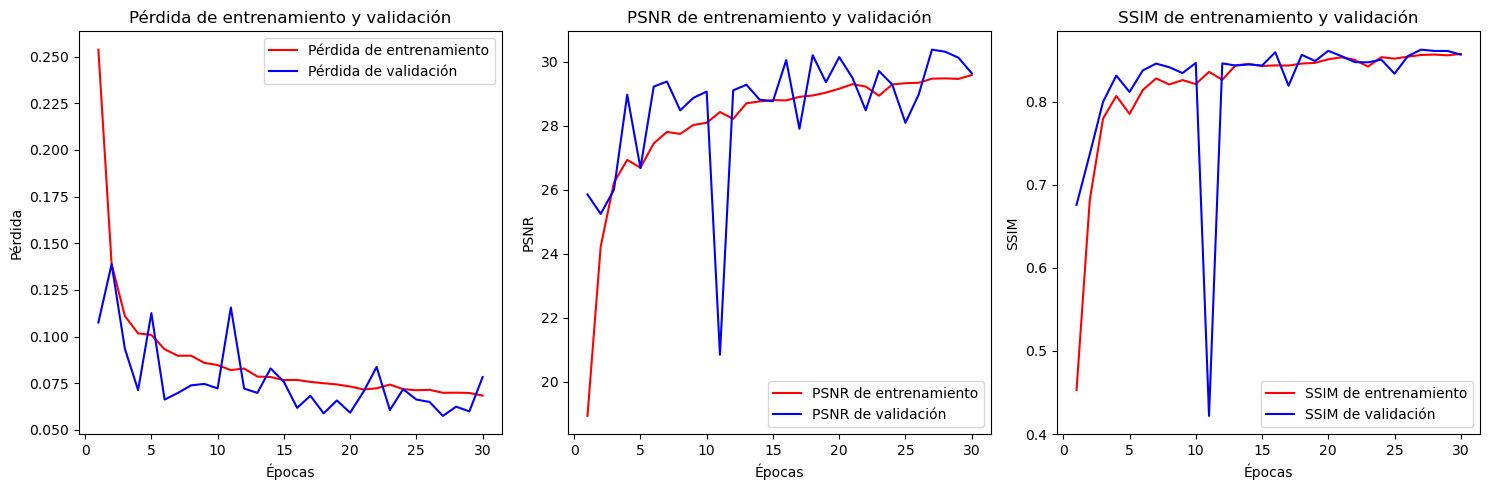

In [ ]:
# Obtener las métricas del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
psnr = history.history['psnr_metric']
val_psnr = history.history['val_psnr_metric']
ssim = history.history['ssim_metric']
val_ssim = history.history['val_ssim_metric']

epochs = range(1, len(loss) + 1)

# Crear una figura con 3 subgráficas en una fila
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Graficar la pérdida
axs[0].plot(epochs, loss, 'r', label='Pérdida de entrenamiento')
axs[0].plot(epochs, val_loss, 'b', label='Pérdida de validación')
axs[0].set_title('Pérdida de entrenamiento y validación')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

# Graficar el PSNR
axs[1].plot(epochs, psnr, 'r', label='PSNR de entrenamiento')
axs[1].plot(epochs, val_psnr, 'b', label='PSNR de validación')
axs[1].set_title('PSNR de entrenamiento y validación')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('PSNR')
axs[1].legend()

# Graficar el SSIM
axs[2].plot(epochs, ssim, 'r', label='SSIM de entrenamiento')
axs[2].plot(epochs, val_ssim, 'b', label='SSIM de validación')
axs[2].set_title('SSIM de entrenamiento y validación')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('SSIM')
axs[2].legend()

# Ajustar el layout
plt.tight_layout()
plt.show()

In [ ]:

# Evaluación en el conjunto de validación
loss, psnr_value, ssim_value = gan_model.evaluate(validation_low_mri, validation_high_mri)
print(f"Loss: {loss}")
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")


99/99 ━━━━━━━━━━━━━━━━━━━━ 58s 581ms/step - loss: 0.0603 - psnr_metric: 30.3311 - ssim_metric: 0.8813
Loss: 0.078249990940094
PSNR: 29.647300720214844
SSIM: 0.8565287590026855


## Comparativo imágenes

In [ ]:
import random
# Comparativa imágenes
def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    diff = ref_data - target_data
    rmse = math.sqrt(np.mean(diff**2.))
    if rmse == 0:
        return float('inf')
    return 20 * math.log10(255. / rmse)

def ssim(target, ref):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    target = target.astype(np.float64)
    ref = ref.astype(np.float64)

    mu1 = np.mean(target)
    mu2 = np.mean(ref)
    sigma1 = np.std(target)
    sigma2 = np.std(ref)
    sigma12 = np.mean((target - mu1) * (ref - mu2))

    ssim_value = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 ** 2 + sigma2 ** 2 + C2))
    return ssim_value

def mae(target, ref):
    return np.mean(np.abs(ref - target))

def mse(target, ref):
  return np.mean((ref.astype(np.float64) - target.astype(np.float64)) ** 2)

def compare_images(target, ref):
    target = np.clip(target, 0, 255)
    ref = np.clip(ref, 0, 255)
    if target.ndim == 3 and target.shape[-1] == 1:
        target = target.squeeze(-1)
    if ref.ndim == 3 and ref.shape[-1] == 1:
        ref = ref.squeeze(-1)
    psnr_score = psnr(target, ref)
    ssim_score = ssim(ref, target)
    mse_score = mse(ref, target)
    return [psnr_score, ssim_score, mse_score]

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High MRI', color='black', fontsize=20)
    plt.imshow(high, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Low MRI', color='black', fontsize=20)
    plt.imshow(low, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Predicted MRI', color='black', fontsize=20)
    plt.imshow(predicted, cmap='gray')
    plt.axis('off')
    plt.show()

# Lista para almacenar los resultados como diccionarios
results_data = []
indices = list(range(len(test_low_mri)))
random.shuffle(indices)

# Iterar sobre una muestra de índices
for i in indices[:10]:
    # Realizar la predicción
    predicted = gan_model.predict(test_low_mri[i].reshape(1, SIZE, SIZE, 1))
    
    # Procesar la imagen predicha
    pred_img = predicted[0].squeeze()
    pred_img = np.clip(pred_img, 0, 255)
    
    # Comparar imágenes y obtener scores
    score = compare_images(pred_img, test_high_mri[i])
    
    # Almacenar el número de imagen y los scores en un diccionario
    results_data.append({
        'Número de Imagen': i, 
        'PSNR': score[0],
        'SSIM': score[1],
        'MSE': score[2]
    })
    
    # Mostrar imágenes 
    plot_images(test_high_mri[i], test_low_mri[i], pred_img)

# Crear DataFrame de resultados a partir de la lista de diccionarios
df_scores = pd.DataFrame(results_data)

df_scores = df_scores[['Número de Imagen', 'PSNR', 'SSIM', 'MSE']]
df_scores = df_scores.round(4)
# Mostrar el DataFrame
print(df_scores)

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


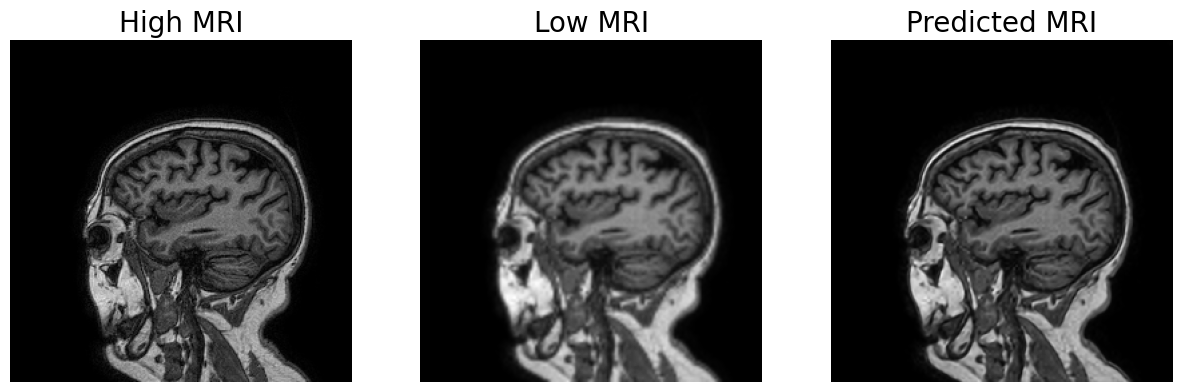

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


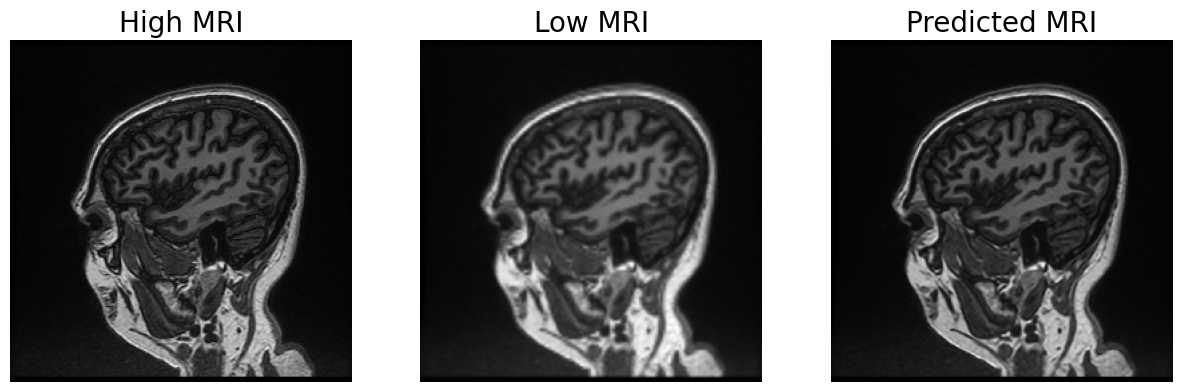

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


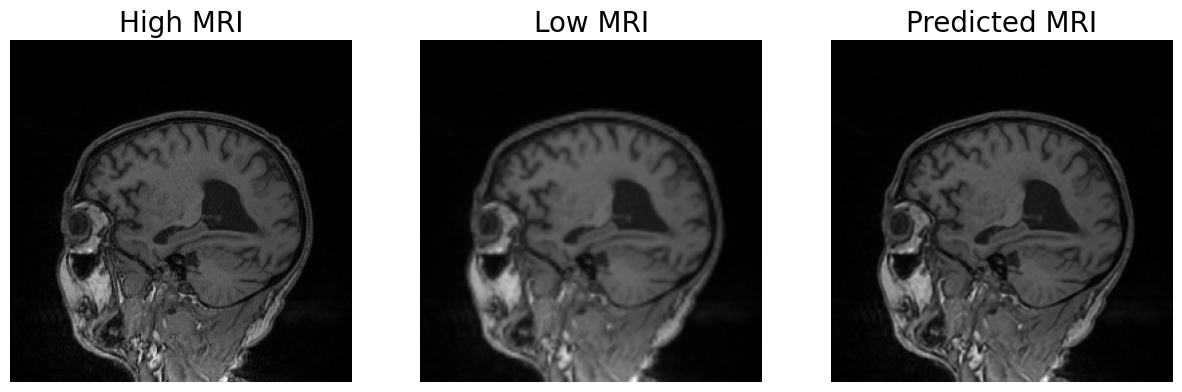

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


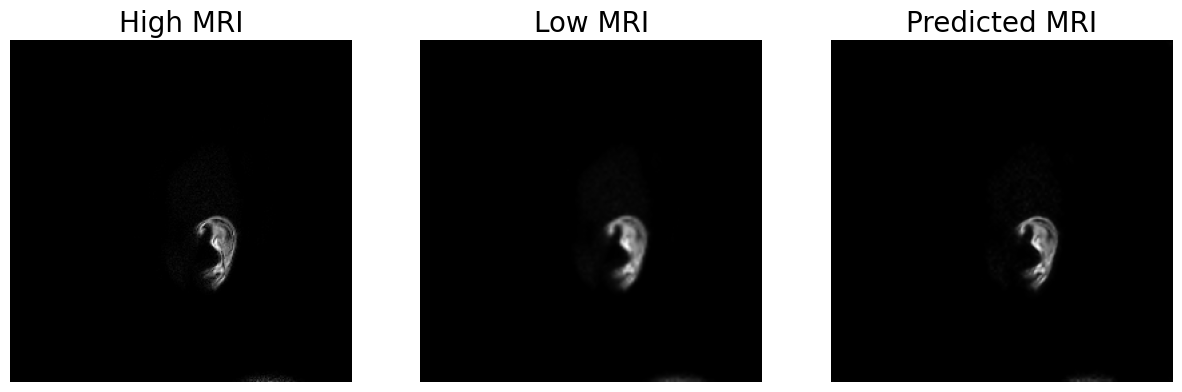

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


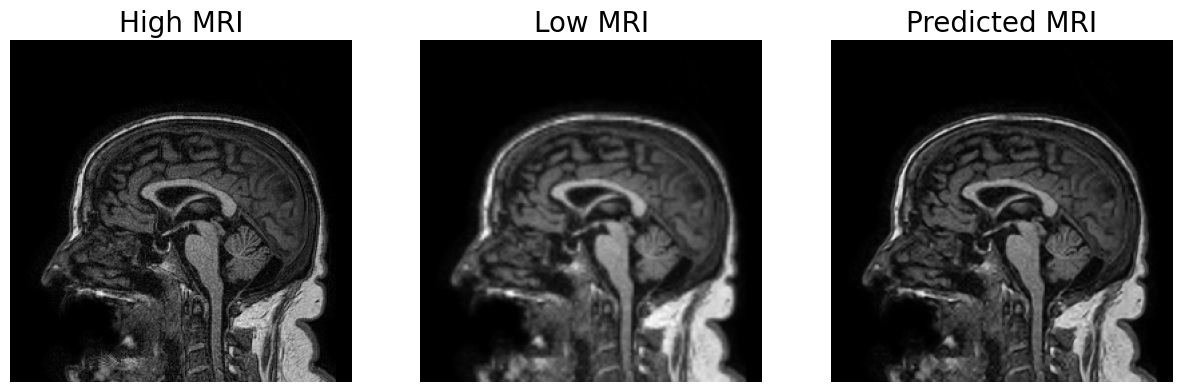

        PSNR      SSIM       MAE
0  80.265746  0.985739  0.012827
1  58.439438  0.986944  0.172628
2  63.981041  0.984615  0.093461
3  94.612709  0.986975  0.000929
4  79.667485  0.975661  0.015267


In [ ]:
import random
# Comparativa imágenes
def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    diff = ref_data - target_data
    rmse = math.sqrt(np.mean(diff**2.))
    if rmse == 0:
        return float('inf')
    return 20 * math.log10(255. / rmse)

def ssim(target, ref):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    target = target.astype(np.float64)
    ref = ref.astype(np.float64)

    mu1 = np.mean(target)
    mu2 = np.mean(ref)
    sigma1 = np.std(target)
    sigma2 = np.std(ref)
    sigma12 = np.mean((target - mu1) * (ref - mu2))

    ssim_value = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 ** 2 + sigma2 ** 2 + C2))
    return ssim_value

def mae(target, ref):
    return np.mean(np.abs(ref - target))

def compare_images(target, ref):
    # Asegúrate de que las imágenes estén en el rango [0, 255]
    target = np.clip(target, 0, 255)
    ref = np.clip(ref, 0, 255)
    # Si es necesario, elimina el canal extra
    if target.ndim == 3 and target.shape[-1] == 1:
        target = target.squeeze(-1)
    if ref.ndim == 3 and ref.shape[-1] == 1:
        ref = ref.squeeze(-1)
    psnr_score = psnr(target, ref)
    ssim_score = ssim(ref, target)
    mae_score = mae(ref, target)
    return [psnr_score, ssim_score, mae_score]

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High MRI', color='black', fontsize=20)
    plt.imshow(high, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Low MRI', color='black', fontsize=20)
    plt.imshow(low, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Predicted MRI', color='black', fontsize=20)
    plt.imshow(predicted, cmap='gray')
    plt.axis('off')
    plt.show()

# Comparar imágenes y almacenar resultados
scores = []
indices = list(range(len(test_low_mri)))
random.shuffle(indices)
for i in indices[:5]:
    predicted = gan_model.predict(test_low_mri[i].reshape(1, SIZE, SIZE, 1))
    # Asegúrate de que predicted esté en el mismo rango y forma que las imágenes originales
    pred_img = predicted[0].squeeze()
    pred_img = np.clip(pred_img, 0, 255)
    score = compare_images(pred_img, test_high_mri[i])
    scores.append(score)
    plot_images(test_high_mri[i], test_low_mri[i], pred_img)

# Crear DataFrame de resultados
df_scores = pd.DataFrame(scores, columns=['PSNR', 'SSIM', 'MAE'])
print(df_scores)


In [ ]:
# Obtener la hora de finalización del entrenamiento
end_time = datetime.now()
print(f"Entrenamiento finalizado a las: {end_time.strftime('%H:%M:%S')}")

# Calcular el tiempo total de entrenamiento
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time}") 

Entrenamiento finalizado a las: 21:39:54
Tiempo total de entrenamiento: 10:47:59.262989


In [ ]:
# Guardar el modelo en un archivo HDF5
model.save('modelo_srgan.h5')